
# Overview

By the end of this notebook, you will understand how to-

* Work with the audio data
* Represent an audio data - Time Domain and Spectrogram
* Build a deep learning model while working with audio data

<br>

# Understanding the Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams. 

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

<br>

# Dataset

Download the dataset from [here](https://drive.google.com/file/d/1VBI_X6GyYvf8j3T70-_hVDyhR_sUzeCr/view?usp=sharing)

<br>

## Import Libraries

Let us first import the libraries into our environment

* **Librosa** is an open source library in Python that is used for audio and music analyis

* **Scipy** is a python library for scientific & technical computing. It contains modules for signal processing, image processing, and linear algebera

In [0]:
# For audio processing
import librosa
import scipy

In [3]:
librosa.__version__

'0.6.3'

In [5]:
scipy.__version__  

'1.4.1'

In [0]:
# For playing audio
import IPython.display as ipd

# For array processing
import numpy as np

# For visualization 
import matplotlib.pyplot as plt

# Load Audio Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# extract data
!unzip '/content/drive/My Drive/Course_Notes/Applied DL - Sequence Models/Project 3: Audio Classification/audio.zip'

Archive:  /content/drive/My Drive/Course_Notes/Applied DL - Sequence Models/Project 3: Audio Classification/audio.zip
   creating: audio/
  inflating: audio/emergency.wav     
  inflating: audio/non emergency.wav  


In [0]:
# import emergency vehicle data
path='audio/emergency.wav'
emergency,sample_rate = librosa.load(path, sr = 16000)

# import non-emergency vehicle data
path='audio/non emergency.wav'
non_emergency,sample_rate = librosa.load(path, sr =16000)

We have used the sampling rate (sr) of 16000 to read the above audio data. An audio wave of 2 seconds with a sampling rate of 16,000 will have 32,000 samples.

__Find the duration of the audio clips__

In [0]:
duration1 = librosa.get_duration(emergency,sr=16000)
duration2 = librosa.get_duration(non_emergency,sr=16000)

print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


## Preparing Data

Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task

In [0]:
def prepare_data(audio_data, num_of_samples=32000, sr=16000):
  
  data=[]
  for offset in range(0, len(audio_data), sr):
    start = offset
    end   = offset + num_of_samples
    chunk = audio_data[start:end]
    
    if(len(chunk)==32000):
      data.append(chunk)
    
  return data

Call the above function

In [0]:
# prepare audio chunks
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [0]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Lets listen to some of the clips

In [0]:
ipd.Audio(emergency[136],rate=16000)

In [0]:
ipd.Audio(non_emergency[10],rate=16000)

## Visualization of Audio Data

Let's visualize the audio wave in time domain

Text(0, 0.5, 'Amplitude')

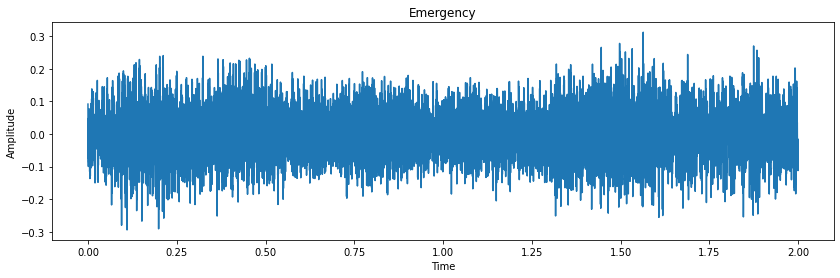

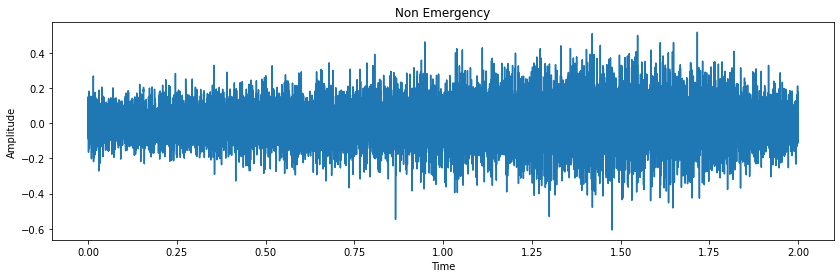

In [0]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

__Combine Emergecy and Non Emergency chunks__

In [0]:
audio = np.concatenate([emergency,non_emergency])

In [0]:
# assign labels 
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

Take a glance at the shape of the combined data.

In [0]:
print(audio.shape)

(3002, 32000)


**Split into train and validation set**

Next, we will train the model on 90% of the data and validate on the remaining 10%:

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                            stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [0]:
x_tr.shape, x_val.shape

((2701, 32000), (301, 32000))

The input must be 3 dimensional array - (no. of examples, timesteps, features)

So, lets reshape our input array according to the required shape

In [0]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


## Model Architecture

Let's define the model architecture using conv1D layers  and the time domain features.

In [0]:
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, GlobalMaxPool1D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# CNN based deep learning model architecture
def conv_model(x_tr):
  
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  # Global MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer 
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)
  
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  
  return model, model_checkpoint

Using TensorFlow backend.


__Call the model__

In [0]:
model, model_checkpoint = conv_model(x_tr_features)

Understand the shape and parameters at each layer

In [0]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32000, 1)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32000, 8)          112       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32000, 8)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 16000, 8)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 16000, 16)         1424      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16000, 16)         0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8000, 16)          0   

Lets train the model for 10 epochs:

In [0]:
# model training
history = model.fit(x_tr_features, y_tr ,epochs=10, 
                    callbacks=[model_checkpoint], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Train on 2701 samples, validate on 301 samples
Epoch 1/10
2701/2701 [==============================] - 3s 1ms/step - loss: 0.6410 - acc: 0.6653 - val_loss: 0.6146 - val_acc: 0.7940

Epoch 00001: val_loss improved from inf to 0.61456, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 3s 1ms/step - loss: 0.4784 - acc: 0.8241 - val_loss: 0.4756 - val_acc: 0.8671

Epoch 00002: val_loss improved from 0.61456 to 0.47563, saving model to best_model.hdf5
Epoch 3/10
2701/2701 [==============================] - 3s 1ms/step - loss: 0.3643 - acc: 0.8530 - val_loss: 0.4055 - val_acc: 0.8771

Epoch 00003: val_loss improved from 0.47563 to 0.40550, saving model to best_model.hdf5
Epoch 4/10
2701/2701 [==============================] - 3s 1ms/step - loss: 0.3295 - acc: 0.8667 - val_loss: 0.3783 - val_acc: 0.8671

Epoch 00004: val_loss improved from 0.40550 to 0.37827, saving model to best_model.hdf5
Epoch 5/10
2701/2701 [==============================] - 3s 1ms/st

In [0]:
# load the best model weights
model.load_weights('best_model.hdf5')

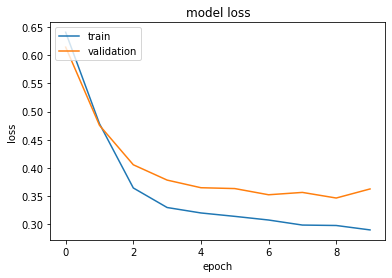

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluate the model on hold out set

In [0]:
# check model's performance on the validation set
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

301/301 [==============================] - 0s 420us/step
Validation Accuracy: 0.880398690700531


**Inference**

Let us make predictions on the hold out set

In [0]:
# input audio

ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [0]:
# classification
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency' 

print("Prediction:",pred)

Prediction: non emergency


<br>

Let's define the model architecture using LSTM layers and the time domain features.

In [0]:
# reshape chunks
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [0]:
from keras.layers import LSTM

# LSTM based deep learning model architecture
def lstm_model(x_tr):
  
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  
  return model

In [0]:
model = lstm_model(x_tr_features)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 160)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               147968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 156,289
Trainable params: 156,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [0]:
history=model.fit(x_tr_features, y_tr, epochs=10, 
                  callbacks=[mc], batch_size=32, 
                  validation_data=(x_val_features,y_val))

Train on 2701 samples, validate on 301 samples
Epoch 1/10
2701/2701 [==============================] - 32s 12ms/step - loss: 0.6504 - acc: 0.6016 - val_loss: 0.5493 - val_acc: 0.7043

Epoch 00001: val_loss improved from inf to 0.54930, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 30s 11ms/step - loss: 0.6168 - acc: 0.6660 - val_loss: 0.5024 - val_acc: 0.7575

Epoch 00002: val_loss improved from 0.54930 to 0.50239, saving model to best_model.hdf5
Epoch 3/10
2701/2701 [==============================] - 30s 11ms/step - loss: 0.5374 - acc: 0.7297 - val_loss: 0.5501 - val_acc: 0.7043

Epoch 00003: val_loss did not improve from 0.50239
Epoch 4/10
2701/2701 [==============================] - 30s 11ms/step - loss: 0.4997 - acc: 0.7505 - val_loss: 0.6664 - val_acc: 0.5814

Epoch 00004: val_loss did not improve from 0.50239
Epoch 5/10
2701/2701 [==============================] - 32s 12ms/step - loss: 0.6338 - acc: 0.6453 - val_loss: 0.5893 - val_acc: 0.

In [0]:
# load best model weights
model.load_weights('best_model.hdf5')

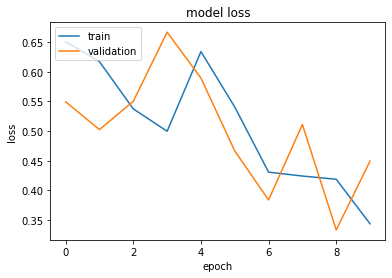

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

301/301 [==============================] - 0s 1ms/step
Accuracy: 0.8903654217720032


## Spectrogram Features

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies FFT on each window to compute the frequencies.

Coming to the parameters for computing spectrogram: 

* nperseg = Size of the window i.e. number of samples in each chunk
* noverlap= Number of overlapping samples between each window

In [0]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160

    freqs, times, spec = scipy.signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg,noverlap=noverlap)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Define a function for representing spectrogram:

In [0]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_title('Spectrogram of '+label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabel('Seconds')

Compute the spectrogram:

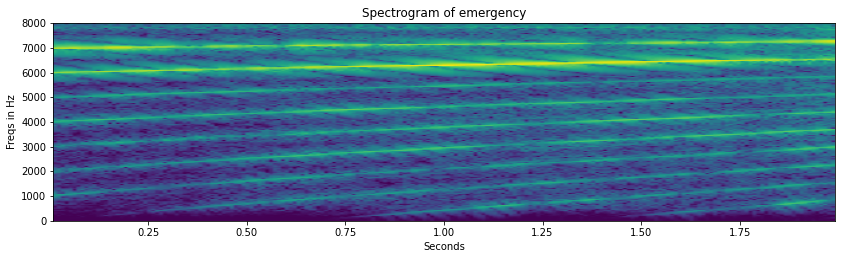

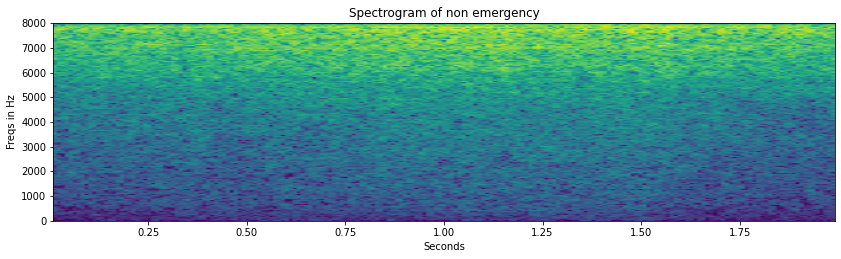

In [0]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [0]:
spectrogram.shape

(199, 161)

__Extract the spectrogram features__

In [0]:
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram = log_specgram(i, sample_rate)
    
    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    
    features.append(spectrogram)

  return np.array(features)

In [0]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

__Call the LSTM Model__

In [0]:
model_2 = lstm_model(x_tr_features)

In [0]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Understand the no. of parameters and shape of each layer:

In [0]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 199, 161)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               148480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 156,801
Trainable params: 156,801
Non-trainable params: 0
_________________________________________________________________


Train the model

In [0]:
history=model_2.fit(x_tr_features, y_tr, 
                    epochs=10, callbacks=[mc], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Train on 2701 samples, validate on 301 samples
Epoch 1/10
2701/2701 [==============================] - 31s 11ms/step - loss: 0.2376 - acc: 0.9115 - val_loss: 0.2095 - val_acc: 0.9302

Epoch 00001: val_loss improved from inf to 0.20945, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 31s 12ms/step - loss: 0.2630 - acc: 0.9041 - val_loss: 0.4244 - val_acc: 0.7940

Epoch 00002: val_loss did not improve from 0.20945
Epoch 3/10
2701/2701 [==============================] - 31s 11ms/step - loss: 0.2153 - acc: 0.9200 - val_loss: 0.2689 - val_acc: 0.9003

Epoch 00003: val_loss did not improve from 0.20945
Epoch 4/10
2701/2701 [==============================] - 32s 12ms/step - loss: 0.1496 - acc: 0.9456 - val_loss: 0.3771 - val_acc: 0.8339

Epoch 00004: val_loss did not improve from 0.20945
Epoch 5/10
2701/2701 [==============================] - 31s 12ms/step - loss: 0.1618 - acc: 0.9426 - val_loss: 0.3072 - val_acc: 0.8771

Epoch 00005: val_loss did not i

Load the weights of the best model:

In [0]:
model_2.load_weights('best_model.hdf5')

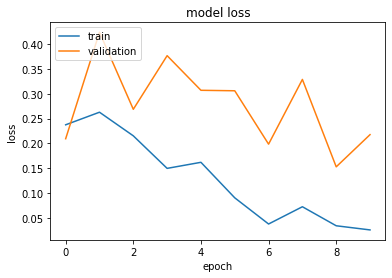

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model on validation set:

In [0]:
_,acc = model_2.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

301/301 [==============================] - 0s 1ms/step
Accuracy: 0.960132896900177


<br>

Lets train the CNN based model on the same spectrogram features.


In [0]:
model_3, mc = conv_model(x_tr_features)

Understand the input and output shape of each layer:

In [0]:
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 199, 161)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 199, 8)            16752     
_________________________________________________________________
dropout_4 (Dropout)          (None, 199, 8)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 99, 16)            1424      
_________________________________________________________________
dropout_5 (Dropout)          (None, 99, 16)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 16)            0   

Training the model:

In [0]:
history=model_3.fit(x_tr_features, y_tr, 
                    epochs=10, callbacks=[mc], batch_size=32, 
                    validation_data=(x_val_features,y_val))

Train on 2701 samples, validate on 301 samples
Epoch 1/10
2701/2701 [==============================] - 2s 846us/step - loss: 0.6183 - acc: 0.7134 - val_loss: 0.4861 - val_acc: 0.7641

Epoch 00001: val_loss improved from inf to 0.48608, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 1s 233us/step - loss: 0.3269 - acc: 0.8671 - val_loss: 0.4076 - val_acc: 0.8173

Epoch 00002: val_loss improved from 0.48608 to 0.40755, saving model to best_model.hdf5
Epoch 3/10
2701/2701 [==============================] - 1s 230us/step - loss: 0.2567 - acc: 0.9011 - val_loss: 0.3069 - val_acc: 0.8937

Epoch 00003: val_loss improved from 0.40755 to 0.30692, saving model to best_model.hdf5
Epoch 4/10
2701/2701 [==============================] - 1s 219us/step - loss: 0.2151 - acc: 0.9115 - val_loss: 0.2754 - val_acc: 0.9203

Epoch 00004: val_loss improved from 0.30692 to 0.27539, saving model to best_model.hdf5
Epoch 5/10
2701/2701 [==============================] - 1

Load the best saved model

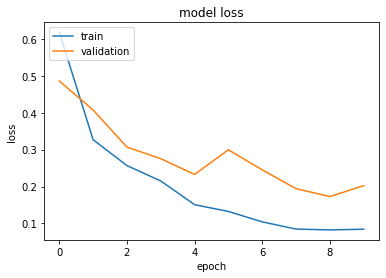

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model:

In [0]:
model_3.load_weights('best_model.hdf5')

In [0]:
# model's performance on the validation set
_,acc = model_3.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

301/301 [==============================] - 0s 162us/step
Accuracy: 0.9235880374908447


### What else to try?

* Different model architectures
* Use Frequency domain features
* Change input sequence length
* more...